# Lezione 21

In [ ]:
from liblet import ANTLR, Tree, Stack, AnnotatedTreeWalker

## Partiamo da SimpleBlockLang

Riprendiamo il linguaggio della scorsa lezione, ma scordandoci dello *scoping* per semplicità.

In [ ]:
SimpleBlockLang = ANTLR.load('SimpleBlockLang.g')
simpleBlock2ast = AnnotatedTreeWalker.load('simpleBlock2ast.atw')

def src2ast(source):
    return simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))

Come "test" usuiamo il solito programma con un campionario di istruzioni diverse…

In [ ]:
source = """
var prodotto = 1;
var n;
if INPUT0 == 3 then
    OUTPUT = 1;
else {
    repeat INPUT0 times {
        n = n + 1;
        prodotto = prodotto * n;
    }
    OUTPUT = prodotto;
}
"""

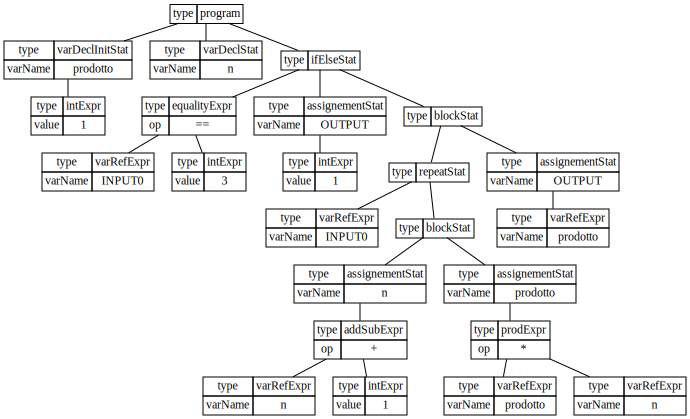

In [ ]:
ast = src2ast(source)
ast

## Un interprete ricorsivo con `AnnotatedTreeWalker`

Usando un `AnnotatedTreeWalker`, definendo una funzione per ciascun tipo di nodo, a partire dagli *atomi*, alle *espressioni* e quindi alle *istruzioni*.

In [ ]:
interpreter = AnnotatedTreeWalker('type')

In [ ]:
# gli atomi

@interpreter.register
def intExpr(visit, ast):
    return ast.root['value']

@interpreter.register
def varRefExpr(visit, ast):
    return interpreter.GLOBAL_MEMORY[ast.root['varName']]

In [ ]:
# istruzioni di dichiarazione e assegnamento

@interpreter.register
def varDeclInitStat(visit, ast):
    interpreter.GLOBAL_MEMORY[ast.root['varName']] = visit(ast.children[0])

@interpreter.register
def varDeclStat(visit, ast):
    interpreter.GLOBAL_MEMORY[ast.root['varName']] = 0
    
@interpreter.register
def assignementStat(visit, ast):
    interpreter.GLOBAL_MEMORY[ast.root['varName']] = visit(ast.children[0])

In [ ]:
# le espressioni binarie

@interpreter.register
def addSubExpr(visit, ast):
    left = visit(ast.children[0])
    right = visit(ast.children[1])
    if ast.root['op'] == '+':
        return left + right
    elif ast.root['op'] == '-':
        return left - right

@interpreter.register
def prodExpr(visit, ast):
    left = visit(ast.children[0])
    right = visit(ast.children[1])
    return left * right

@interpreter.register
def equalityExpr(visit, ast):
    left = visit(ast.children[0])
    right = visit(ast.children[1])
    return left == right

In [ ]:
# controllo del flusso

@interpreter.register
def ifStat(visit, ast):
    cond, stat = ast.children
    if visit(cond): visit(stat)
        
@interpreter.register
def ifElseStat(visit, ast):
    cond, true, false = ast.children
    if visit(cond): 
        visit(true)
    else:
        visit(false)
        
@interpreter.register
def repeatStat(visit, ast):
    count, stat = ast.children
    count = visit(count)
    for _ in range(count): visit(stat)

In [ ]:
# quel che resta

@interpreter.register
def blockStat(visit, ast):
    for stat in ast.children: visit(stat)

@interpreter.register
def program(visit, ast):
    for stat in ast.children: visit(stat)
    return interpreter.GLOBAL_MEMORY['OUTPUT']

Un test su 6 (resituisce il fattoriale) e su 3 (restituisce 1)

In [ ]:
interpreter.GLOBAL_MEMORY = {'INPUT0': 6}        
interpreter(ast)

720

In [ ]:
interpreter.GLOBAL_MEMORY = {'INPUT0': 3}        
interpreter(ast)

1

## Un linguaggio con funzioni

Estendiamo l'interprete al caso di un linguaggio con funzioni (che supporti la ricorsione).

### Grammatica e AST

Inisiamo con le aggiunte alla grammatica…

In [ ]:
SimpleFuncLang = ANTLR(r"""grammar SimpleFuncLang;

program: functionDecl+ ;

functionDecl: 'function' ID '(' formalParameters? ')' block ;
formalParameters: ID (',' ID)* ;

block: '{' stat* '}' ;

expr: ID '(' exprList? ')' # funcCallExpr
    | '!' expr             # notExpr
    | expr '*' expr        # prodExpr
    | expr ('+'|'-') expr  # addSubExpr
    | expr '==' expr       # equalityExpr
    | ID                   # varRefExpr
    | INT                  # intExpr
    | '(' expr ')'         # subExpr
    ;

exprList: expr (',' expr)* ;

stat: block                                # blockStat
    | 'var' ID ('=' expr)? ';'             # varDeclStat
    | 'if' expr 'then' stat ('else' stat)? # ifElseStat
    | 'repeat' expr 'times' stat           # repeatStat
    | 'return' expr? ';'                   # returnStat
    | ID '=' expr ';'                      # assignementStat
    | expr ';'                             # exprStat
    ;

ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

Adattiamo la trasformazione all'AST

In [ ]:
# ripartiamo da quella di SimpleBlockLang

simpleFunc2ast = AnnotatedTreeWalker.load('simpleBlock2ast.atw')

def src2ast(source):
    return simpleFunc2ast(SimpleFuncLang.tree(source, 'program'))

I casi semplici

In [ ]:
# ora anche una espressione è una istruzione

@simpleFunc2ast.register
def exprStat(visit, ast):
    return Tree({'type': 'exprStat'}, [visit(ast.children[0])])

# si è aggiunta anche l'istruzione return

@simpleFunc2ast.register
def returnStat(visit, ast):
    if len(ast.children) == 3:
        _, expr, _ = ast.children
        return Tree({'type': 'returnStat'}, [visit(expr)])
    else:
        return Tree({'type': 'returnStat'})
    
# e va gestito il bloco come figlio delle definizioni di funzione

@simpleFunc2ast.register
def block(visit, ast):
    return Tree({'type': 'blockStat'}, [visit(stat) for stat in ast.children[1:-1]])

Nella dichiarazione di funzione teniamo da parte i *parametri formali* nell'attributo `params`, mentre nell'invocazione raccogliamo le espressioni corrispondenti ai *parametri attuali* come flgli del nodo… 

In [ ]:
@simpleFunc2ast.register
def functionDecl(visit, ast):
    if len(ast.children) == 6:
        _, name, _, params, _, block = ast.children
    else:
        _, name, _, _, block = ast.children
        params = []
    block = visit(block)
    params = [param.root['value'] for param in params.children[::2]] if params else []
    return Tree({'type': 'function', 'funcName': name.root['value'], 'params': params}, [block])

@simpleFunc2ast.register
def funcCallExpr(visit, ast):
    if len(ast.children) == 4:
        func, _, args, _ = ast.children
        args = args.children[::2]
    else:
        func, _, _ = ast.children
        args = []
    return Tree({'type': 'funcCallExpr', 'funcName': func.root['value']}, [visit(arg) for arg in args])

Testiamo sul calcolo del fattoriale…

In [ ]:
fact_source = r"""
function fact(n) {
    if n == 0 then
        return 1;
    else
        return n * fact(n - 1);
}

function main() {
    OUTPUT = fact(INPUT0);
}
"""

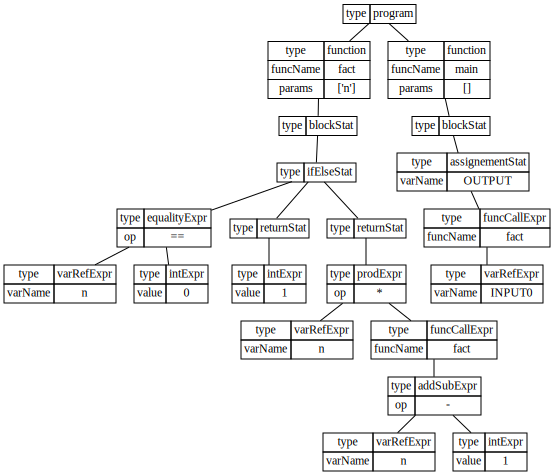

In [ ]:
fact_ast = src2ast(fact_source)
fact_ast

### Interpretazione e record d'attivazione

Sostituiamo la memoria globale con una pila `ACTIVATION_RECORDS` di *record di attivazione*, questo influisce dapprima su espressioni ed istruzioni che hanno a che fare con la memoria

In [ ]:
@interpreter.register
def varRefExpr(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    return local_memory[ast.root['varName']]
 
@interpreter.register
def varDeclStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory[ast.root['varName']] = 0    
    
@interpreter.register
def varDeclInitStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory[ast.root['varName']] = visit(ast.children[0])
    
@interpreter.register
def assignementStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory[ast.root['varName']] = visit(ast.children[0])

Le funzioni sono raccolte in una mappa `FUNCTIONS` che associa i nomi di funzioni al loro albero, il programma eseguirà la funzione di nome `main`, eseguire una funzione significa visitare il blocco da cui è costituita.

In [ ]:
@interpreter.register
def program(visit, ast):
    interpreter.FUNCTIONS = {func.root['funcName']: func for func in ast.children}
    visit(interpreter.FUNCTIONS['main'])
    return interpreter.ACTIVATION_RECORDS.pop()['OUTPUT']

L'invocazione di una funzione è preceduta dall'allocazione sulla pila di un record di attivazione dato da una mappa dai nomi di variabile al loro valore… 

In [ ]:
# visitare una funzione corrisponde ad eseguirne il corpo

@interpreter.register
def function(visit, ast):
    visit(ast.children[0])
    
# la chiamata richiede l'allocazione/deallocazione del record di attivazione    
    
@interpreter.register
def funcCallExpr(visit, ast):
    function = interpreter.FUNCTIONS[ast.root['funcName']]
    interpreter.ACTIVATION_RECORDS.push(dict(zip(
        function.root['params'],
        [visit(arg) for arg in ast.children]
    )))
    visit(function) # questo scarica su quanto definito poco sopra
    return interpreter.ACTIVATION_RECORDS.pop()['_retval'] 

Il caso dell'istruzione `return` è gestito aggiungendo una variaible locale dal nome `_retval` per conservare il valore restituito.

In [ ]:
@interpreter.register
def returnStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory['_retval'] = visit(ast.children[0]) if ast.children else None

Vediamo se calcola il fattoriale

In [ ]:
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 6}])
interpreter(fact_ast)

720

Un altro esempio, con Fibonacci

In [ ]:
fib_source = r"""
function fib(n) {
    if n == 1 then
        return 1;
    else if n == 2 then
        return 1;
    else 
        return fib(n-1) + fib(n-2);
}

function main() {
    OUTPUT = fib(INPUT0);
}
"""

In [ ]:
fib_ast = src2ast(fib_source)

In [ ]:
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 10}])
interpreter(fib_ast)

55

### L'uscita anticipata con `return`

Il codice seguente dovrebbe eseguire il ciclo una sola volta, restituendo 1.

In [ ]:
source_noret = r"""
function noret() {
    somma = 0;
    repeat 10 times {
        return 1;
        somma = somma + 1;
    }
    return somma;
}

function main() {
    OUTPUT = noret(INPUT0);
}
"""

In [ ]:
ast_noret = src2ast(source_noret)
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 11}])
interpreter(ast_noret)

10

Ciò che accade è che alcuni nodi che ciclano sui sottoalberi non osservano per tempo la presenza di `_retval` nell'ultimo record di attivazione. La correzione è semplice.

In [ ]:
@interpreter.register
def blockStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    for stat in ast.children: 
        if '_retval' in local_memory: return
        visit(stat)

@interpreter.register
def repeatStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    count, stat = ast.children
    count = visit(count)
    for _ in range(count): 
        if '_retval' in local_memory: return
        visit(stat)        

In [ ]:
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 11}])
interpreter(ast_noret)

1